In [1]:
import sys 
sys.path.append('../') 
import numpy as np 
import matplotlib.pyplot as plt 
from VQE import VQE 
from qiskit.providers.aer import AerSimulator 
from qiskit.providers.aer.noise import NoiseModel  
from utils import * 
from qiskit import IBMQ, Aer, QuantumCircuit 
from qiskit.circuit.library import EfficientSU2 
from qiskit.utils.quantum_instance import QuantumInstance 
from qiskit.algorithms import NumPyMinimumEigensolver 
from qiskit.algorithms.optimizers import SPSA 
from GroupingAlgorithm import grouping, groupingWithOrder 
from HEEM_VQE_Functions_Luciano import * 
from qiskit.circuit.random import random_circuit 
from qiskit.compiler import transpile 

from qiskit.providers.aer.noise import NoiseModel 
from qiskit.providers.aer.noise import pauli_error 

In [2]:
IBMQ.load_account()
provider      = IBMQ.get_provider(hub='ibm-q-csic', group='internal', project='iff-csic') 
backend_exp   = provider.get_backend('ibmq_guadalupe')  
#backend_sim = Aer.get_backend( 'aer_simulator' ) 
backend_sim = AerSimulator.from_backend(backend_exp) 
shots = 2**16

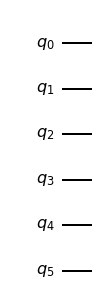

In [3]:
H, variational_circuit = BeH2(initial_state=True) 
H = H.to_pauli_op()
num_qubits = H.num_qubits 
variational_circuit = QuantumCircuit(num_qubits) 
#variational_circuit.compose( EfficientSU2( num_qubits, reps=1, entanglement='linear' ),  inplace=True ) 
num_params = variational_circuit.num_parameters 
variational_circuit.decompose().draw(output='mpl') 

In [4]:
WC_exp = get_backend_connectivity(backend_exp)
WC_exp = [  indx for indx in WC_exp if indx[0]<num_qubits and indx[1]<num_qubits  ]

In [5]:
ExpVal_theo = []
ExpVal_TPB  = []
ExpVal_EM   = []
ExpVal_HEEM = []

MC = 1

for k in range( MC ) :

    params = np.pi*np.random.randn(num_params)

    paulis, coeff, labels = Label2Chain( H )
    
    ###
    Color, Groups, Measurements = TPBgrouping( paulis )
    prob2Exp = probability2expected( coeff, labels, Groups, Measurements)
    circuits = [ measure_circuit_factor( measure , num_qubits )[0].compose( variational_circuit, front=True  ).assign_parameters(params)
                for measure in Measurements ]
    circuits = transpile( circuits, backend=backend_sim )
    if k == 0 :
        num_cnot = [ circuit.num_nonlocal_gates() for circuit in circuits ]
        depth    = [ circuit.depth() for circuit in circuits ]
        print( len(Measurements), np.mean(num_cnot), np.mean(depth) )
    counts = backend_sim.run( circuits, shots=int( shots/len(Measurements) ) ).result().get_counts()
    probs = [ post_process_results( count, num_qubits, shots ) for count in counts ]
    ExpVal = 0
    for j in range(len(probs)):
        ExpVal += np.sum(prob2Exp[j]@probs[j])
    ExpVal_TPB.append( ExpVal )
    
    ###
    del Groups, Measurements
    Groups, Measurements, T = groupingWithOrder( paulis )
    prob2Exp = probability2expected( coeff, labels, Groups, Measurements)
    circuits = [ measure_circuit_factor( measure , num_qubits )[0].compose( variational_circuit, front=True  ).assign_parameters(params)
                for measure in Measurements ]    
    circuits = transpile( circuits, backend=backend_sim, initial_layout=T )
    circuits_1 = circuits
    if k == 0 :
        num_cnot = [ circuit.num_nonlocal_gates() for circuit in circuits ]
        depth    = [ circuit.depth() for circuit in circuits ]
        print( len(Measurements), np.mean(num_cnot), np.mean(depth), T )
    counts = backend_sim.run( circuits, shots=int( shots/len(Measurements) )  ).result().get_counts()
    probs = [ post_process_results( count, num_qubits, shots ) for count in counts ]
    ExpVal = 0
    for j in range(len(probs)):
        ExpVal += np.sum(prob2Exp[j]@probs[j])
    ExpVal_EM.append( ExpVal )

    ####
    del Groups, Measurements
    Groups, Measurements, T = groupingWithOrder( paulis, G = WC_exp )
    prob2Exp = probability2expected( coeff, labels, Groups, Measurements)
    circuits = [ measure_circuit_factor( measure , num_qubits )[0].compose( variational_circuit, front=True  ).assign_parameters(params)
                for measure in Measurements ]
    circuits = transpile( circuits, backend=backend_sim, initial_layout=T )
    if k == 0 :
        num_cnot = [ circuit.num_nonlocal_gates() for circuit in circuits ]
        depth    = [ circuit.depth() for circuit in circuits ]
        print( len(Measurements), np.mean(num_cnot), np.mean(depth), T )
    counts = backend_sim.run( circuits, shots=int( shots/len(Measurements) )  ).result().get_counts()
    probs = [ post_process_results( count, num_qubits, shots ) for count in counts ]
    ExpVal = 0
    for j in range(len(probs)):
        ExpVal += np.sum(prob2Exp[j]@probs[j])
    ExpVal_HEEM.append( ExpVal )
    ####

    ExpVal_theo.append( H.to_matrix()[0,0] )  

24 0.0 3.8333333333333335
13 5.461538461538462 8.846153846153847 [0, 1, 2, 3, 4, 5]


c:\Users\lucia\Nextcloud\Programas\Github\Hardware-efficient-variational-quantum-eigensolver-with-entangled-measurements\Codes\experiments\..\HEEM_VQE_Functions_Luciano.py:307: DeprecationWarning: The QuantumCircuit.u2 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You can use the general 1-qubit gate QuantumCircuit.u instead: u2(φ,λ) = u(π/2, φ, λ). Alternatively, you can decompose it interms of QuantumCircuit.p and QuantumCircuit.sx: u2(φ,λ) = p(π/2+φ) sx p(λ-π/2) (1 pulse on hardware).
  circuit.u2(0, np.pi / 2, qubits[0])


19 1.0526315789473684 5.368421052631579 [0, 1, 2, 3, 5, 4]


In [6]:
ExpVal_theo = np.array(ExpVal_theo)
ExpVal_TPB  = np.array(ExpVal_TPB)
ExpVal_EM   = np.array(ExpVal_EM)
ExpVal_HEEM = np.array(ExpVal_HEEM)
mean= [ np.mean( np.abs(ExpVal_theo-ExpVal_TPB) ), np.mean( np.abs(ExpVal_theo-ExpVal_EM) ), np.mean( np.abs( ExpVal_theo- ExpVal_HEEM) ) ]
std = [ np.std( np.abs(ExpVal_theo-ExpVal_TPB) ), np.std( np.abs(ExpVal_theo-ExpVal_EM) ), np.std( np.abs( ExpVal_theo- ExpVal_HEEM) ) ]
mean, std

([0.015858815826876933, 0.03499822222092547, 0.012659704135186096],
 [0.0, 0.0, 0.0])

[Text(0, 0, 'TPB'), Text(1, 0, 'EM'), Text(2, 0, 'HEEM')]

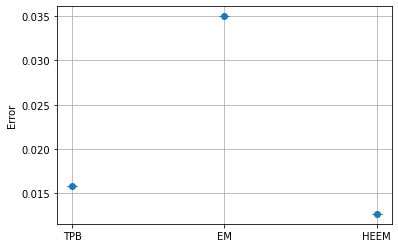

In [7]:
fig, ax = plt.subplots()
ax.errorbar( [0,1,2], mean, std, capsize=5, fmt='o' )
ax.grid()
ax.set_ylabel('Error')
ax.set_xticks([0,1,2])
ax.set_xticklabels(['TPB','EM','HEEM'])

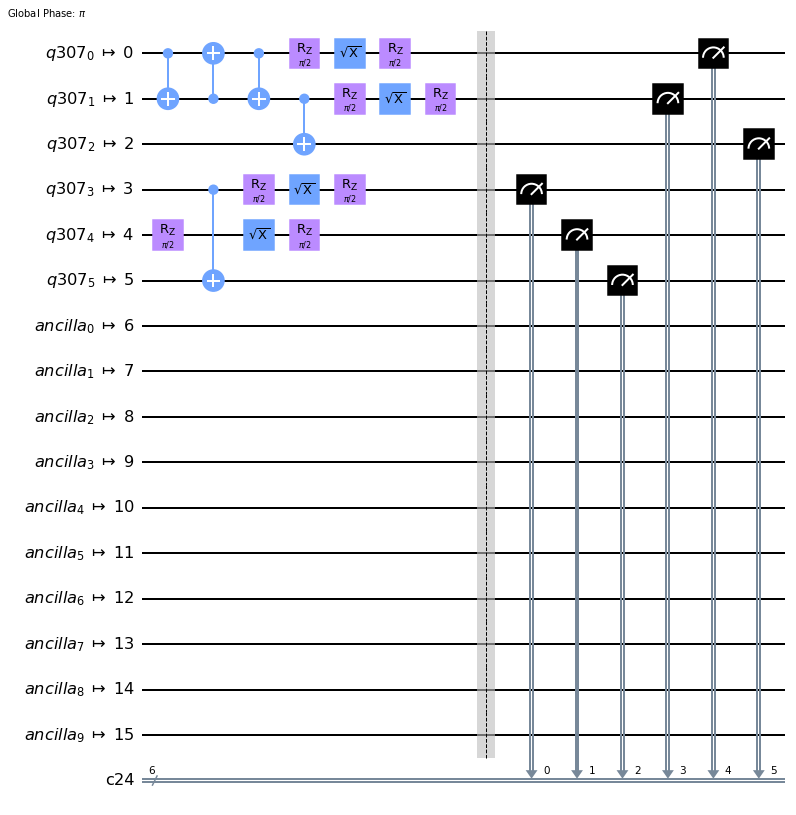

In [8]:
circuits_1[0].draw(output='mpl')

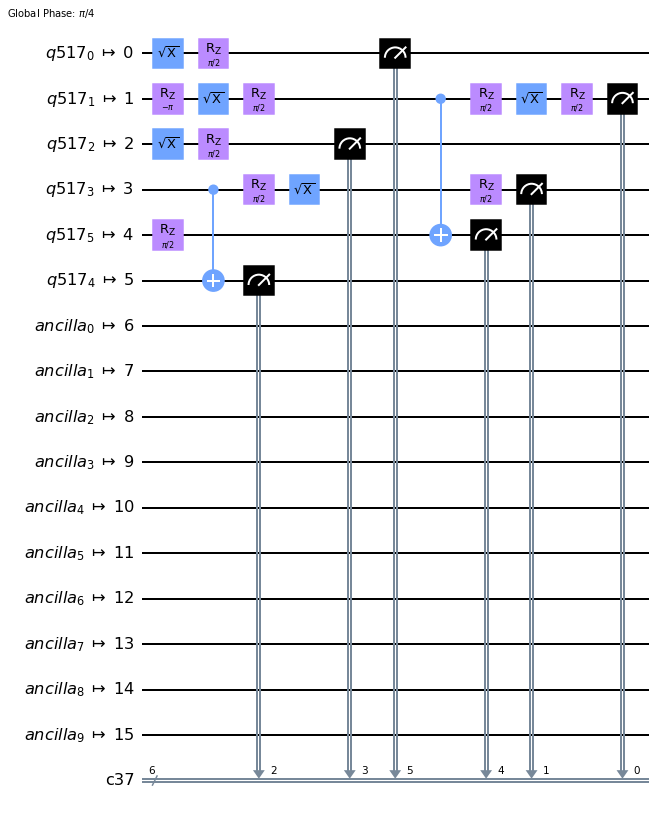

In [9]:
circuits[0].draw(output='mpl')

In [10]:
T

[0, 1, 2, 3, 5, 4]

In [11]:
WC_exp

[(0, 1),
 (1, 0),
 (1, 2),
 (1, 4),
 (2, 1),
 (2, 3),
 (3, 2),
 (3, 5),
 (4, 1),
 (5, 3)]

In [12]:
num_cnot

[2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]

In [13]:
Measurements

[[[2, [2]], [5, [1, 5]], [2, [0]], [4, [3, 4]]],
 [[1, [2]], [4, [0, 1]], [2, [5]], [7, [3, 4]]],
 [[2, [0]], [4, [2, 3]], [7, [1, 5]], [1, [4]]],
 [[3, [5]], [4, [3, 4]], [3, [2]], [4, [0, 1]]],
 [[3, [0]], [4, [1, 2]], [1, [5]], [6, [3, 4]]],
 [[1, [2]], [4, [0, 1]], [1, [5]], [4, [3, 4]]],
 [[3, [0]], [4, [1, 2]], [1, [3]], [2, [4]], [2, [5]]],
 [[3, [2]], [4, [0, 1]], [3, [4]], [3, [3]], [1, [5]]],
 [[1, [2]], [1, [0]], [1, [5]], [6, [3, 4]], [3, [1]]],
 [[3, [3]], [3, [5]], [3, [4]], [7, [0, 1]], [2, [2]]],
 [[3, [1]], [3, [2]], [3, [0]], [2, [5]], [7, [3, 4]]],
 [[1, [2]], [2, [4]], [9, [1, 5]], [1, [3]], [1, [0]]],
 [[3, [3]], [3, [4]], [3, [5]], [1, [0]], [4, [1, 2]]],
 [[3, [0]], [1, [1]], [4, [2, 3]], [3, [5]], [1, [4]]],
 [[3, [1]], [3, [2]], [3, [0]], [1, [3]], [1, [4]], [1, [5]]],
 [[3, [4]], [1, [2]], [1, [3]], [1, [0]], [1, [5]], [3, [1]]],
 [[1, [0]], [0, [1]], [0, [2]], [0, [3]], [2, [4]], [2, [5]]],
 [[3, [2]], [3, [3]], [3, [0]], [3, [5]], [1, [1]], [1, [4]]],
 [[3, 